#Setting up

In [ ]:
!pip install geopandas

In [ ]:
from google.colab import drive as dr
dr.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
root_path = '/content/gdrive/My Drive/Colab Notebooks/MasterProject_WildFirePrediction'

In [ ]:
root_path+ 'b'

'/content/gdrive/My Drive/Colab Notebooks/MasterProject_WildFirePredictionb'

In [ ]:
import pandas as pd
import numpy as np
import datetime 
from geopandas import GeoDataFrame
from shapely.geometry import Polygon 
import fiona

In [ ]:
# sns.set(font_scale=1.4)
import os
import pickle
from yellowbrick.classifier import ClassificationReport
#Plot the Precision-Recall curve (AP-Average Precision)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn import metrics
from IPython.display import Image
from pylab import *
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from shapely.geometry import Polygon 
from geopandas import GeoDataFrame,geoseries
from datetime import datetime, date, timedelta
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
from sklearn import metrics

import fiona
import ee, folium, datetime
import pandas as pd
import seaborn as sns
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!pip install scikit-plot
import scikitplot as skplt
from yellowbrick.classifier.rocauc import roc_auc,ROCAUC
from sklearn.model_selection import learning_curve, ShuffleSplit


plt.rcParams['figure.figsize']=10,10
%matplotlib inline

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import imblearn
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
# cv = StratifiedKFold(n_splits=3, shuffle=True)
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LogisticRegression
 
#from sklearn.model_selection import train_test_split

This colab has vegetaion data with fire one week before fire as positive and 

all records one week before that as no fire -- and it also has the non fire grids (indices) as well for each fire day

#Import vegetation data

Below is 8 day aggregate vegetation data for all years from 2014 to 2019



In [ ]:
downloaded_veg = drive.CreateFile({'id':'1eRfdmOvwxt5YgTeq_oHcnXo8fA18U13Y'}) 
downloaded_veg.GetContentFile('vegetation.csv')
veg_dat = pd.read_csv('vegetation.csv')
veg_dat.head()

Unnamed: 0        left  ...  fire_2014_MONTICELLO2  target
0           0 -122.124189  ...                  False   False
1           1 -122.124189  ...                  False   False
2           2 -122.124189  ...                  False   False
3           3 -122.124189  ...                  False   False
4           4 -122.124189  ...                  False   False

[5 rows x 33 columns]

In [ ]:
veg_dat.shape

(17388, 33)

#Filter vegetation data fro years - 2015,2016,2017,2018 as we do no have 2014 weather data

In [ ]:
veg_dat['Start Date'] = pd.to_datetime(veg_dat['Start Date'])

In [ ]:
veg_train = veg_dat[(veg_dat['Start Date'] > datetime.datetime(2014, 12, 31)) & (veg_dat['Start Date'] < datetime.datetime(2019, 1, 1))]

In [ ]:
veg_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11592 entries, 46 to 17341
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             11592 non-null  int64         
 1   left                   11592 non-null  float64       
 2   top                    11592 non-null  float64       
 3   right                  11592 non-null  float64       
 4   bottom                 11592 non-null  float64       
 5   id                     11592 non-null  int64         
 6   geometry               11592 non-null  object        
 7   Centroid Longitude     11592 non-null  float64       
 8   Centroid Latitude      11592 non-null  float64       
 9   Start Date             11592 non-null  datetime64[ns]
 10  End Date               11592 non-null  object        
 11  NDVI                   11592 non-null  float64       
 12  EVI                    11592 non-null  float64       
 13  

#Convert target to 0 and 1

In [ ]:
veg_train['target'] = veg_train['target'].astype(int)

In [ ]:
veg_train['target'].value_counts()

0    11470
1      122
Name: target, dtype: int64

2015 fire : start- 2015/07/22 end -2015/08/05  

2016 fire : start- 2016/08/02 end - 2016/08/09

2017 fire : start- 2017/07/06 end - 2017/07/12

2018 fire : start- 2018/06/30 end - 2018/07/11

#Create postive and negative vegetation data

In [ ]:
#create 1 day layer of positive data
veg_2015_positive = veg_train[(veg_train['Start Date'] == pd.to_datetime('2015-07-12'))] #positive 2015-07-12 negative 2015-07-04 --  8 day aggregate before fire 
veg_2016_positive = veg_train[(veg_train['Start Date'] == pd.to_datetime('2016-07-27'))] #positive 2016-07-27 negative 2016-07-19 --8 day aggregate before fire, but for 2016 we took next record as the fire started on 2016-08-2  
veg_2017_positive = veg_train[(veg_train['Start Date'] == pd.to_datetime('2017-06-26'))] #positive 2017-06-26 negative 2017-06-18 --  8 day aggregate before fire 
veg_2018_positive = veg_train[(veg_train['Start Date'] == pd.to_datetime('2018-06-18'))] #positive 2018-06-18   negative 2018-06-10 --  8 day aggregate before fire 

In [ ]:
veg_wragg = veg_train[veg_train['fire_2015_WRAGG2'] == True]
veg_cold = veg_train[veg_train['fire_2016_COLD2'] == True]
veg_winter = veg_train[veg_train['fire_2017_WINTER2'] == True]
veg_county = veg_train[veg_train['fire_2018_COUNTY2'] == True]

In [ ]:
veg_2015_index = veg_wragg['id'].value_counts().index.tolist()
veg_2016_index = veg_cold['id'].value_counts().index.tolist()
veg_2017_index = veg_winter['id'].value_counts().index.tolist()
veg_2018_index = veg_county['id'].value_counts().index.tolist()

In [ ]:
veg_2015_index

[63, 28, 27, 56, 55, 21, 20, 49, 48, 14, 13, 42, 41, 7, 35, 34]

In [ ]:
veg_2015_positive.loc[veg_2015_positive['id'].isin(veg_2015_index), 'target'] = 1
veg_2015_positive.loc[~veg_2015_positive['id'].isin(veg_2015_index), 'target'] = 0
veg_2016_positive.loc[veg_2016_positive['id'].isin(veg_2016_index), 'target'] = 1
veg_2016_positive.loc[~veg_2016_positive['id'].isin(veg_2016_index), 'target'] = 0
veg_2017_positive.loc[veg_2017_positive['id'].isin(veg_2017_index), 'target'] = 1
veg_2017_positive.loc[~veg_2017_positive['id'].isin(veg_2017_index), 'target'] = 0
veg_2018_positive.loc[veg_2018_positive['id'].isin(veg_2018_index), 'target'] = 1
veg_2018_positive.loc[~veg_2018_positive['id'].isin(veg_2018_index), 'target'] = 0

In [ ]:
print(veg_2015_positive['target'].value_counts())
print(len(veg_2015_index))

0    47
1    16
Name: target, dtype: int64
16


In [ ]:
print(veg_2016_positive['target'].value_counts())
print(len(veg_2016_index))

1    43
0    20
Name: target, dtype: int64
43


In [ ]:
print(veg_2017_positive['target'].value_counts())
print(len(veg_2017_index))

0    46
1    17
Name: target, dtype: int64
17


In [ ]:
print(veg_2018_positive['target'].value_counts())
print(len(veg_2018_index))

1    46
0    17
Name: target, dtype: int64
46


In [ ]:
#create 1 day layer of empty data
veg_2015_empty = veg_train[(veg_train['Start Date'] == pd.to_datetime('2015-07-04'))]
veg_2016_empty = veg_train[(veg_train['Start Date'] == pd.to_datetime('2016-07-19'))]
veg_2017_empty = veg_train[(veg_train['Start Date'] == pd.to_datetime('2017-06-26'))]
veg_2018_empty = veg_train[(veg_train['Start Date'] == pd.to_datetime('2018-06-18'))]

In [ ]:
veg_2015_empty.columns

Index(['Unnamed: 0', 'left', 'top', 'right', 'bottom', 'id', 'geometry',
       'Centroid Longitude', 'Centroid Latitude', 'Start Date', 'End Date',
       'NDVI', 'EVI', 'NDWI', 'topLeft_coords', 'topRight_coords',
       'bottomLeft_coords', 'bottomRight_coords', 'centroid_coords',
       'midLeft_coords', 'midRight_coords', 'midTop_coords',
       'midBottom_coords', 'diagonal1', 'diagonal2', 'diagonal3', 'diagonal4',
       'fire_2018_COUNTY2', 'fire_2017_WINTER2', 'fire_2016_COLD2',
       'fire_2015_WRAGG2', 'fire_2014_MONTICELLO2', 'target'],
      dtype='object')

#Vegetation seperate model

In [ ]:
#DATA_PATH = "/content/drive/Data"
root_path = '/content/gdrive/My Drive/Colab Notebooks/MasterProject_WildFirePrediction/30th_april'
infile = open(root_path+'/rf_veg_30th_apr.pkl','rb')
rf_veg = pickle.load(infile)

# Download Positive weather data

In [ ]:
downloaded1 = drive.CreateFile({'id':'1EMqiSn9snQCPicKFfiHhxir1yzEMoKDU'}) 
downloaded1.GetContentFile('WRAGG_2015_test.csv')
dat_2015 = pd.read_csv('WRAGG_2015_test.csv')
dat_2015['target'].value_counts()

0    1128
1     384
Name: target, dtype: int64

In [ ]:
dat_2015['DATE'].value_counts()

2015-07-22 05:53:00    63
2015-07-22 10:53:00    63
2015-07-22 16:53:00    63
2015-07-22 04:53:00    63
2015-07-22 11:53:00    63
2015-07-22 07:53:00    63
2015-07-22 20:53:00    63
2015-07-22 19:53:00    63
2015-07-22 03:53:00    63
2015-07-22 08:53:00    63
2015-07-22 14:53:00    63
2015-07-22 06:53:00    63
2015-07-22 12:53:00    63
2015-07-22 23:53:00    63
2015-07-22 02:53:00    63
2015-07-22 01:53:00    63
2015-07-22 17:53:00    63
2015-07-22 21:53:00    63
2015-07-22 18:53:00    63
2015-07-22 22:53:00    63
2015-07-22 15:53:00    63
2015-07-22 13:53:00    63
2015-07-22 09:53:00    63
2015-07-22 00:53:00    63
Name: DATE, dtype: int64

In [ ]:
downloaded2 = drive.CreateFile({'id':'1-2ZD_NZcxQQ-T-1DszSiNNeCo6ibx2Ht'}) 
downloaded2.GetContentFile('COLD_2016_test.csv')
dat_2016 = pd.read_csv('COLD_2016_test.csv')
dat_2016['target'].value_counts()

1    1032
0     480
Name: target, dtype: int64

In [ ]:
dat_2016['DATE'].value_counts()

2016-08-02 08:53:00    63
2016-08-02 09:53:00    63
2016-08-02 01:53:00    63
2016-08-02 14:53:00    63
2016-08-02 12:53:00    63
2016-08-02 05:53:00    63
2016-08-02 18:53:00    63
2016-08-02 23:53:00    63
2016-08-02 20:53:00    63
2016-08-02 03:53:00    63
2016-08-02 00:53:00    63
2016-08-02 02:53:00    63
2016-08-02 16:53:00    63
2016-08-02 06:53:00    63
2016-08-02 15:53:00    63
2016-08-02 21:53:00    63
2016-08-02 22:53:00    63
2016-08-02 19:53:00    63
2016-08-02 17:53:00    63
2016-08-02 10:53:00    63
2016-08-02 07:53:00    63
2016-08-02 04:53:00    63
2016-08-02 13:53:00    63
2016-08-02 11:53:00    63
Name: DATE, dtype: int64

In [ ]:
# downloaded3 = drive.CreateFile({'id':'1-6ATDvR4YZn7j9fcnaQc1ZRLhMFY6ovs'}) 
# downloaded3.GetContentFile('WINTER_2017during_train.csv')
# dat_2017 = pd.read_csv('WINTER_2017during_train.csv')
# dat_2017['target'].value_counts()
downloaded3 = drive.CreateFile({'id':'1-6ATDvR4YZn7j9fcnaQc1ZRLhMFY6ovs'}) 
downloaded3.GetContentFile('WINTER_2017during_train.csv')
dat_2017 = pd.read_csv('WINTER_2017during_train.csv')
dat_2017['target'].value_counts()

0    1104
1     408
Name: target, dtype: int64

In [ ]:
dat_2017['DATE'].value_counts()

2017-07-06 20:53:00    63
2017-07-06 23:53:00    63
2017-07-06 09:53:00    63
2017-07-06 08:53:00    63
2017-07-06 15:53:00    63
2017-07-06 19:53:00    63
2017-07-06 07:53:00    63
2017-07-06 11:53:00    63
2017-07-06 00:53:00    63
2017-07-06 02:53:00    63
2017-07-06 22:53:00    63
2017-07-06 17:53:00    63
2017-07-06 18:53:00    63
2017-07-06 21:53:00    63
2017-07-06 01:53:00    63
2017-07-06 16:53:00    63
2017-07-06 10:53:00    63
2017-07-06 12:53:00    63
2017-07-06 03:53:00    63
2017-07-06 14:53:00    63
2017-07-06 04:53:00    63
2017-07-06 13:53:00    63
2017-07-06 05:53:00    63
2017-07-06 06:53:00    63
Name: DATE, dtype: int64

In [ ]:
downloaded8 = drive.CreateFile({'id':'1-CR7IkiZ2PnNROZQqBpkZDDpqzMT-NQN'}) 
downloaded8.GetContentFile('COUNTY_2018during_train.csv')
dat_2018 = pd.read_csv('COUNTY_2018during_train.csv')
dat_2018['target'].value_counts()
# downloaded8 = drive.CreateFile({'id':'1-CR7IkiZ2PnNROZQqBpkZDDpqzMT-NQN'}) 
# downloaded8.GetContentFile('COUNTY_2018during_train.csv')
# dat_2018 = pd.read_csv('COUNTY_2018during_train.csv')
# dat_2018['target'].value_counts()

1    1104
0     408
Name: target, dtype: int64

In [ ]:
dat_2018['DATE'].value_counts()

2018-06-30 09:53:00    63
2018-06-30 05:53:00    63
2018-06-30 21:53:00    63
2018-06-30 22:53:00    63
2018-06-30 10:53:00    63
2018-06-30 04:53:00    63
2018-06-30 13:53:00    63
2018-06-30 12:53:00    63
2018-06-30 19:53:00    63
2018-06-30 07:53:00    63
2018-06-30 06:53:00    63
2018-06-30 11:53:00    63
2018-06-30 18:53:00    63
2018-06-30 17:53:00    63
2018-06-30 20:53:00    63
2018-06-30 02:53:00    63
2018-06-30 15:53:00    63
2018-06-30 23:53:00    63
2018-06-30 03:53:00    63
2018-06-30 00:53:00    63
2018-06-30 01:53:00    63
2018-06-30 16:53:00    63
2018-06-30 08:53:00    63
2018-06-30 14:53:00    63
Name: DATE, dtype: int64

# Dowload negative weather data

2015 -- negative weather date - 2015-07-11

2016 -- negative weather date - 2016-07-26

2017 -- negative weather date - 2017-06-25

2018 -- negative weather date - 2018-06-17

In [ ]:
downloaded4 = drive.CreateFile({'id':'1Owi-fRO1nAsflHLloBilzOsdGePsXRIQ'}) # https://drive.google.com/open?id=1Owi-fRO1nAsflHLloBilzOsdGePsXRIQ 
downloaded4.GetContentFile('WRAGG_2015before_train.csv')
empty_2015 = pd.read_csv('WRAGG_2015before_train.csv')
empty_2015['target'] = 0
empty_2015['target'].value_counts()

0    1512
Name: target, dtype: int64

In [ ]:
empty_2015['DATE'].value_counts()

2015-07-11 02:53:00    63
2015-07-11 10:53:00    63
2015-07-11 09:53:00    63
2015-07-11 11:53:00    63
2015-07-11 22:53:00    63
2015-07-11 20:53:00    63
2015-07-11 01:53:00    63
2015-07-11 19:53:00    63
2015-07-11 00:53:00    63
2015-07-11 13:53:00    63
2015-07-11 16:53:00    63
2015-07-11 04:53:00    63
2015-07-11 15:53:00    63
2015-07-11 18:53:00    63
2015-07-11 17:53:00    63
2015-07-11 03:53:00    63
2015-07-11 07:53:00    63
2015-07-11 06:53:00    63
2015-07-11 08:53:00    63
2015-07-11 21:53:00    63
2015-07-11 14:53:00    63
2015-07-11 12:53:00    63
2015-07-11 05:53:00    63
2015-07-11 23:53:00    63
Name: DATE, dtype: int64

In [ ]:
downloaded5 = drive.CreateFile({'id':'1-2XPDpG_njoiFDfrGtAuUuNivhW-0f7W'}) # https://drive.google.com/open?id=1-2XPDpG_njoiFDfrGtAuUuNivhW-0f7W
downloaded5.GetContentFile('COLD_2016before_train.csv')
empty_2016 = pd.read_csv('COLD_2016before_train.csv')
empty_2016['target'] = 0
empty_2016['target'].value_counts()

0    1512
Name: target, dtype: int64

In [ ]:
# downloaded6 = drive.CreateFile({'id':'1-3gwEb8ql1UuBrOoC2b7vU0w-OWUga0V'}) #https://drive.google.com/open?id=1-3gwEb8ql1UuBrOoC2b7vU0w-OWUga0V
# downloaded6.GetContentFile('WINTER_2017before_train.csv')
# empty_2017 = pd.read_csv('WINTER_2017before_train.csv')
# empty_2017['target'] = 0
# empty_2017['target'].value_counts()
downloaded6 = drive.CreateFile({'id':'1xT6K8I12O6o9S5u53UyTcI1F1NcAOLTo'})  #https://drive.google.com/open?id=1-3gwEb8ql1UuBrOoC2b7vU0w-OWUga0V
downloaded6.GetContentFile('WINTER_2017before_2017.csv')
empty_2017 = pd.read_csv('WINTER_2017before_2017.csv')
empty_2017['target'] = 0
empty_2017['target'].value_counts()



0    1512
Name: target, dtype: int64

In [ ]:
empty_2017['DATE'].value_counts()

2017-06-25 11:53:00    63
2017-06-25 05:53:00    63
2017-06-25 04:53:00    63
2017-06-25 10:53:00    63
2017-06-25 19:53:00    63
2017-06-25 16:53:00    63
2017-06-25 08:53:00    63
2017-06-25 17:53:00    63
2017-06-25 18:53:00    63
2017-06-25 22:53:00    63
2017-06-25 23:53:00    63
2017-06-25 12:53:00    63
2017-06-25 13:53:00    63
2017-06-25 01:53:00    63
2017-06-25 07:53:00    63
2017-06-25 00:53:00    63
2017-06-25 14:53:00    63
2017-06-25 06:53:00    63
2017-06-25 20:53:00    63
2017-06-25 21:53:00    63
2017-06-25 02:53:00    63
2017-06-25 03:53:00    63
2017-06-25 09:53:00    63
2017-06-25 15:53:00    63
Name: DATE, dtype: int64

In [ ]:
# downloaded9 = drive.CreateFile({'id':'1-8G2Jhuy9c5yxR3m3YSICn4ps7ljrnTw'}) #https://drive.google.com/open?id=1-8G2Jhuy9c5yxR3m3YSICn4ps7ljrnTw
# downloaded9.GetContentFile('COUNTY_2018before_train.csv')
# empty_2018 = pd.read_csv('COUNTY_2018before_train.csv')
# empty_2018['target'] = 0
# empty_2018['target'].value_counts()

downloaded9 = drive.CreateFile({'id':'1-CoXQjM-cZqpvGtEoqRAwVTlAXm545KC'}) #https://drive.google.com/open?id=1-8G2Jhuy9c5yxR3m3YSICn4ps7ljrnTw
downloaded9.GetContentFile('COUNTY_2018before_2017.csv')
empty_2018 = pd.read_csv('COUNTY_2018before_2017.csv')
empty_2018['target'] = 0
empty_2018['target'].value_counts()

0    1449
Name: target, dtype: int64

In [ ]:
empty_2018['DATE'].value_counts()

2018-06-17 18:53:00    63
2018-06-17 03:53:00    63
2018-06-17 14:53:00    63
2018-06-17 23:53:00    63
2018-06-17 11:53:00    63
2018-06-17 01:53:00    63
2018-06-17 19:53:00    63
2018-06-17 17:53:00    63
2018-06-17 13:53:00    63
2018-06-17 04:53:00    63
2018-06-17 02:53:00    63
2018-06-17 16:53:00    63
2018-06-17 15:53:00    63
2018-06-17 08:53:00    63
2018-06-17 21:53:00    63
2018-06-17 07:53:00    63
2018-06-17 09:53:00    63
2018-06-17 12:53:00    63
2018-06-17 05:53:00    63
2018-06-17 06:53:00    63
2018-06-17 22:53:00    63
2018-06-17 10:53:00    63
2018-06-17 20:53:00    63
Name: DATE, dtype: int64

#Powerlines and terrain data

In [ ]:
terrain = drive.CreateFile({'id':'1AJMvspR-nIg2D7QwTGOumK8sIIZ3_KCs'}) 
terrain.GetContentFile('terrain_final.csv')
terrain = pd.read_csv('terrain_final.csv')
terrain.shape

(63, 10)

In [ ]:
terrain.head()

Unnamed: 0  id      slope  ...       right    bottom      aspect
0           0  50  89.992500  ... -122.044189  38.55926  139.637707
1           1  49  89.998609  ... -122.054189  38.49926  125.285883
2           2  52  89.997154  ... -122.044189  38.53926  133.743671
3           3  51  89.991819  ... -122.044189  38.54926  143.619148
4           4  62  89.997294  ... -122.034189  38.50926  135.195475

[5 rows x 10 columns]

In [ ]:
downloaded_powerlines = drive.CreateFile({'id':'1znnGM0Xvz6jyNykLY7U5BZvvPCShiK9W'}) 
downloaded_powerlines.GetContentFile('powerlinefinal.csv')
powerline = pd.read_csv('powerlinefinal.csv')
powerline.head()

Unnamed: 0  ...                                           geometry
0           0  ...  MULTIPOLYGON (((-122.0941886091637 38.54925978...
1           1  ...  MULTIPOLYGON (((-122.0941886091637 38.53925978...
2           2  ...  MULTIPOLYGON (((-122.0941886091637 38.56925978...
3           3  ...  MULTIPOLYGON (((-122.0941886091637 38.55925978...
4           4  ...  MULTIPOLYGON (((-122.1141886091637 38.54925978...

[5 rows x 12 columns]

#seperate weather model terrain and powerlines

In [ ]:
# print(write)

In [ ]:
wea_data = pd.concat([empty_2018, empty_2017, empty_2016,empty_2015,dat_2015,dat_2016,dat_2017,dat_2018], axis = 0, ignore_index=True)

In [ ]:
terrain = terrain[['id', 'aspect',	'hillshade',	'slope']]
wea_veg_ter = pd.merge(wea_data, terrain, on='id')
powerline = powerline[['id', 'kV', 'Status',	'Circuit',	'Length_Mil',	'Length_Fee']]
wea_data = pd.merge(wea_veg_ter, powerline, on='id')

In [ ]:
wea_data.shape

(12033, 25)

In [ ]:
wea_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
       'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'left', 'top', 'right', 'bottom', 'id',
       'Longitude', 'Latitude', 'target', 'geometry', 'aspect', 'hillshade',
       'slope', 'kV', 'Status', 'Circuit', 'Length_Mil', 'Length_Fee'],
      dtype='object')

In [ ]:
wea_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12033 entries, 0 to 12032
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                12033 non-null  int64  
 1   Unnamed: 0.1              12033 non-null  int64  
 2   WBAN                      12033 non-null  int64  
 3   DATE                      12033 non-null  object 
 4   HourlyDryBulbTemperature  12033 non-null  float64
 5   HourlyRelativeHumidity    12033 non-null  float64
 6   HourlyWindSpeed           12033 non-null  float64
 7   HourlyPrecipitation       12033 non-null  float64
 8   left                      12033 non-null  float64
 9   top                       12033 non-null  float64
 10  right                     12033 non-null  float64
 11  bottom                    12033 non-null  float64
 12  id                        12033 non-null  int64  
 13  Longitude                 12033 non-null  float64
 14  Latitu

In [ ]:
wea_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
       'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'left', 'top', 'right', 'bottom', 'id',
       'Longitude', 'Latitude', 'target', 'geometry', 'aspect', 'hillshade',
       'slope', 'kV', 'Status', 'Circuit', 'Length_Mil', 'Length_Fee'],
      dtype='object')

In [ ]:
categories = pd.get_dummies(wea_data[['Status','Circuit']])

In [ ]:
wea_data = pd.concat([wea_data,categories],axis = 1) 

In [ ]:
wea_data.drop(columns={'Status','Circuit'},inplace = True)

In [ ]:
X_1 = wea_data.reset_index(drop=True).drop(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
        'left', 'top', 'right', 'bottom', 'id',
       'target', 'geometry'], axis=1)
y_1 = wea_data['target']

In [ ]:
X_1.shape

(12033, 16)

In [ ]:
X_1.columns

Index(['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'Longitude', 'Latitude', 'aspect', 'hillshade',
       'slope', 'kV', 'Length_Mil', 'Length_Fee', 'Status_Not Operating',
       'Status_Operational', 'Circuit_Other', 'Circuit_Single'],
      dtype='object')

In [ ]:
import imblearn
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X_1, y_1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=1)

In [ ]:
root_path = '/content/gdrive/My Drive/Colab Notebooks/MasterProject_WildFirePrediction/30th_april'
infile = open(root_path+'/rf_weather_30th_apr.pkl','rb')
rf_weather = pickle.load(infile)

In [ ]:

# rf_weather = RandomForestClassifier(n_estimators = 200, random_state = 42)
# rf_weather.fit(X_train, y_train)


In [ ]:
predicted1 =rf_weather.predict(X_test)
accuracy = accuracy_score(y_test, predicted1)
print(accuracy)
y_true, y_pred = y_test, predicted1
results = confusion_matrix(y_true, y_pred) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

0.8607907742998353
Confusion Matrix :
[[1649  172]
 [ 335 1486]]
Accuracy Score : 0.8607907742998353
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1821
           1       0.90      0.82      0.85      1821

    accuracy                           0.86      3642
   macro avg       0.86      0.86      0.86      3642
weighted avg       0.86      0.86      0.86      3642



In [ ]:
# import os
# import pickle
# pickle.dump(rf_weather, open(root_path+'/rf_weather_30th_apr.pkl','wb'))

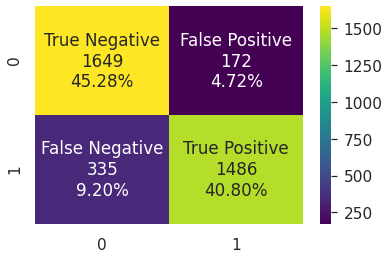

In [ ]:
sns.set(font_scale=1.4)
from sklearn.metrics import confusion_matrix 
import seaborn as sns
cf_matrix = confusion_matrix(y_test, rf_weather.predict(X_test))

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='viridis')


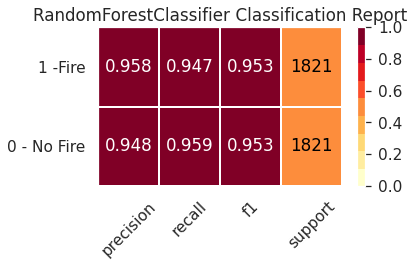

In [ ]:
sns.set(font_scale=1.4)

from yellowbrick.classifier import ClassificationReport
#X_train, X_test, y_train, y_test

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(rf_weather, classes=['0 - No Fire','1 -Fire'], support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()             # Draw/show/poof the data

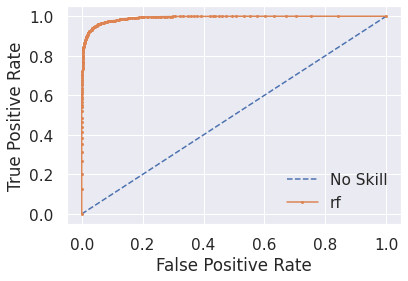

In [ ]:
# roc curve
yhat = rf_weather.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.460000, G-Mean=0.954


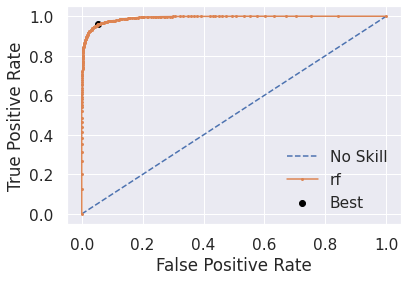

In [ ]:
# show the plot
pyplot.show()
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
#Adjusting the threshold gave better results
threshold = 0.478619

predicted_proba = rf_weather.predict_proba(X_test)
predicted1 = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted1)
print(accuracy)
y_true, y_pred = y_test, predicted1
results = confusion_matrix(y_true, y_pred) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

0.9522240527182867
Confusion Matrix :
[[1733   88]
 [  86 1735]]
Accuracy Score : 0.9522240527182867
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1821
           1       0.95      0.95      0.95      1821

    accuracy                           0.95      3642
   macro avg       0.95      0.95      0.95      3642
weighted avg       0.95      0.95      0.95      3642



Text(0.5, 1.0, '2-class Precision-Recall curve\nwith Average Precision(AP)')

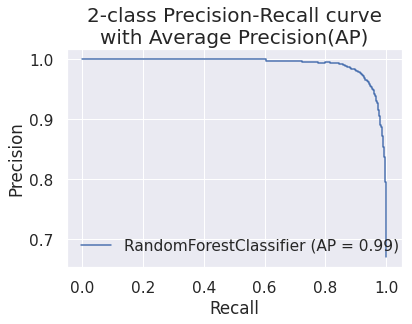

In [ ]:
#Plot the Precision-Recall curve (AP-Average Precision)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(rf_weather, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve\nwith Average Precision(AP)', fontsize=20)

In [ ]:
# print(k)

In [ ]:
from sklearn import metrics

predicted_proba = rf_weather.predict_proba(X_test)
print("Area under the curve (AUC):",metrics.roc_auc_score(y_test, predicted_proba[:,1]))

Area under the curve (AUC): 0.9915497124432417


In [ ]:
from IPython.display import Image
from pylab import *
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from shapely.geometry import Polygon 
from geopandas import GeoDataFrame,geoseries
from datetime import datetime, date, timedelta
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
from sklearn import metrics

import fiona
import ee, folium, datetime
import pandas as pd
import seaborn as sns
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=10,10
%matplotlib inline

Best Threshold=0.460000, G-Mean=0.95


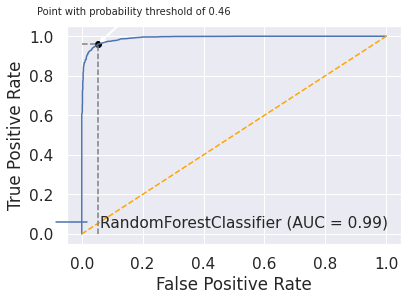

In [ ]:
from sklearn.metrics import plot_roc_curve,roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import math


# Plot the ROC curve
rf_disp = plot_roc_curve(rf_weather, X_test, y_test)

# Generate a no skill prediction (majority class) for proper legend - else use plt.plot([0, 1], ls="--") or use plt.plot([0,1], [0,1], linestyle='--', color = 'orange', label='No Skill ClassifiCATION (AUC=0.5)')
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ns_auc = roc_auc_score(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, color='orange',linestyle='--', label='No Skill Classification (AUC={})'.format(ns_auc))
# Can do for each point threshold value - for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):plt.annotate(np.round(txt,2), (x, y-0.04))

# Calculate roc curve again for understanding the threshold 
fpr, tpr, thresholds = roc_curve(y_test, predicted_proba[:,1])
gmeans = sqrt(tpr * (1-fpr))          # Calculate the g-mean for each threshold as it is ideal for unbalanced dataset
ix = argmax(gmeans)                   # locate the index of the largest g-mean
'''Alternative - Youden’s J statistic to get the same best threshold - Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
J = tpr - fpr; ix = argmax(J); best_thresh = thresholds[ix]'''

# Show the best threshold
print('Best Threshold=%f, G-Mean=%.2f' % (thresholds[ix], gmeans[ix]))
plt.annotate('Point with probability threshold of {}'.format(np.round(thresholds[ix], 2)), 
             xy=(fpr[ix], tpr[ix]), xytext=(fpr[ix]-0.2, tpr[ix]+0.15),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold')
plt.plot([0,fpr[ix]],[tpr[ix],tpr[ix]], ls="--",color='grey');plt.plot([fpr[ix],fpr[ix]],[0,tpr[ix]], ls="--",color='grey');
#plt.legend(frameon=True,framealpha=10); plt.title("Receiver operating characteristic(ROC) curve\nwith Area under the curve(AUC)", fontsize=15)
plt.show()

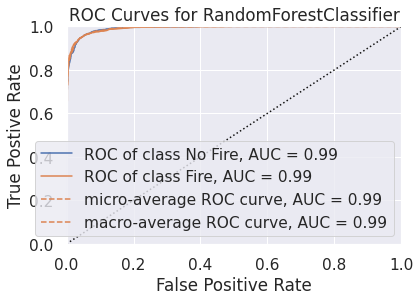

In [ ]:
# Instaniate the classification model and visualizer
from yellowbrick.classifier.rocauc import roc_auc,ROCAUC
visualizer = ROCAUC(rf_weather, classes=["No Fire", "Fire"])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof()                       # Finalize and render the figure

# Wasn't accurate: roc_auc(model_rf, X_train_df, y_train_df,X_test = X_test_df, y_test = y_test_df, classes=['No Fire', 'Fire'])

(0.0, 1.03)

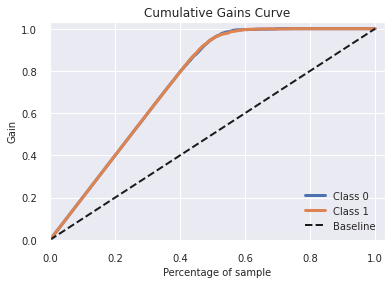

In [ ]:


# Gains curve
skplt.metrics.plot_cumulative_gain(y_test, predicted_proba)
plt.ylim(0,1.03);plt.xlim(0,1.03)

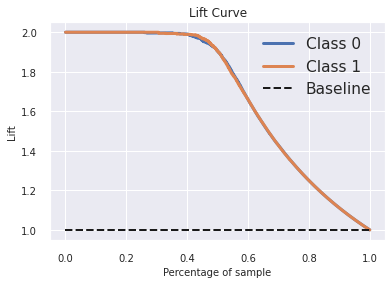

In [ ]:
# Lift curve
skplt.metrics.plot_lift_curve(y_test, predicted_proba)
plt.legend(loc=1)

In [ ]:
# Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.model_selection import learning_curve, ShuffleSplit
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

   
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].set_title("Training scores and Cross-validation scores")
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("Fitting time (ms)")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("Fitting time (ms)")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

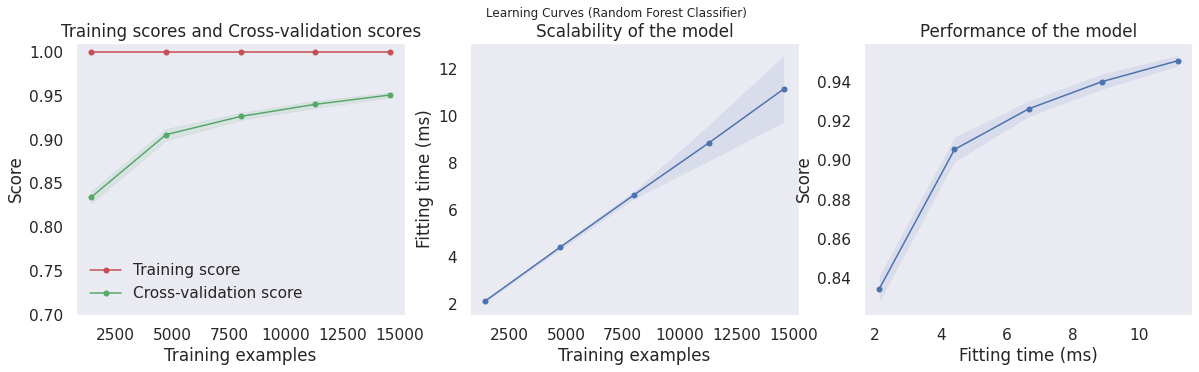

In [ ]:
# Check model performmance and learning curve
#For multiple models, use axes and fig, axes = plt.subplots(3, 1, figsize=(20, 15))

X = pd.concat([pd.DataFrame(X_train),pd.DataFrame(X_test)], axis = 0)
y = pd.concat([pd.Series(y_train),pd.Series(y_test)], axis = 0)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(rf_veg,'Learning Curves (Random Forest Classifier)',X,y,ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)
plt.suptitle("Learning Curves (Random Forest Classifier)")
plt.show()

In [ ]:

feats = {} # a dict to hold feature_name: feature_importance
rf_weather_imp = pd.DataFrame(columns = list('AB') )
j=0
for feature, importance in zip(X_1.columns, rf_weather.feature_importances_):
    #feats[feature] = importance #add the name/value pair 
    rf_weather_imp.loc[j] = [feature,importance]
    j += 1
    #print([feature,importance])

rf_weather_imp = rf_weather_imp.sort_index().sort_values('B',ascending=False)  # sorting by index

In [ ]:
rf_weather_imp

A         B
1     HourlyRelativeHumidity  0.257056
2            HourlyWindSpeed  0.248775
0   HourlyDryBulbTemperature  0.222980
5                   Latitude  0.121790
4                  Longitude  0.036058
8                      slope  0.035914
7                  hillshade  0.032353
6                     aspect  0.027275
12      Status_Not Operating  0.003155
9                         kV  0.002646
14             Circuit_Other  0.002619
10                Length_Mil  0.002574
15            Circuit_Single  0.002393
13        Status_Operational  0.002267
11                Length_Fee  0.002144
3        HourlyPrecipitation  0.000000

#Combine weather data with vegetation data and also terrain and powerlines  (positive)

In [ ]:
terrain.columns

Index(['id', 'aspect', 'hillshade', 'slope'], dtype='object')

In [ ]:
# def combine_datasets(weather, veg):
#   #first preprocess vegetation data
#   veg = veg[['id', 'NDVI', 'NDWI']]
#   dat = pd.merge(weather, veg, on='id')
#   return dat

def combine_datasets(weather, veg, terrain, powerlines):
  #first preprocess vegetation data
  veg = veg[['id', 'NDVI', 'NDWI','EVI']]
  wea_veg = pd.merge(weather, veg, on='id')
  terrain = terrain[['id', 'aspect', 'hillshade', 'slope']]
  wea_veg_ter = pd.merge(wea_veg, terrain, on='id')
  powerlines = powerlines[['id', 'kV', 'Status',	'Circuit',	'Length_Mil',	'Length_Fee']]
  dat = pd.merge(wea_veg_ter, powerlines, on='id')
  return dat

In [ ]:
# dat_2015['id'].value_counts()

In [ ]:
dat_2015 = combine_datasets(dat_2015, veg_2015_positive,terrain,powerline)

In [ ]:
#veg_cold, veg_winter, veg_county
dat_2016 = combine_datasets(dat_2016, veg_2016_positive,terrain,powerline)
dat_2017 = combine_datasets(dat_2017, veg_2017_positive,terrain,powerline)
dat_2018 = combine_datasets(dat_2018, veg_2018_positive,terrain,powerline)

#Combine weather data with vegatation (negative)

In [ ]:
# while we are considering weather and vegetation for fire grids during fire, i think we should consider same grids for before fire as well
negative_2015 = combine_datasets(empty_2015, veg_2015_empty,terrain,powerline)
negative_2016 = combine_datasets(empty_2016, veg_2016_empty,terrain,powerline)
negative_2017 = combine_datasets(empty_2017, veg_2017_empty,terrain,powerline)
negative_2018 = combine_datasets(empty_2018, veg_2018_empty,terrain,powerline)

# create combined training set

In [ ]:
fire = pd.concat([dat_2015, dat_2016,dat_2018, dat_2017], axis = 0, ignore_index=True)

In [ ]:
no_fire = pd.concat([negative_2015,negative_2016,negative_2018,negative_2017], axis = 0, ignore_index=True)

In [ ]:
train = pd.concat([fire, no_fire], axis=0, ignore_index=True)

In [ ]:
train['target'].value_counts()

0    9105
1    2928
Name: target, dtype: int64

In [ ]:
train.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
       'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'left', 'top', 'right', 'bottom', 'id',
       'Longitude', 'Latitude', 'target', 'geometry', 'NDVI', 'NDWI', 'EVI',
       'aspect', 'hillshade', 'slope', 'kV', 'Status', 'Circuit', 'Length_Mil',
       'Length_Fee'],
      dtype='object')

In [ ]:
categories = pd.get_dummies(train[['Status','Circuit']])

In [ ]:
train = pd.concat([train,categories],axis = 1)

In [ ]:
train.drop(columns={'Status','Circuit'},inplace = True)

In [ ]:
train_data = train.reset_index(drop=True)

In [ ]:
train_target = train['target']

In [ ]:
train_data = train_data.drop(['Unnamed: 0', 'Unnamed: 0.1','WBAN','target','DATE','geometry'], axis=1)

In [ ]:
train_target.value_counts()

0    9105
1    2928
Name: target, dtype: int64

In [ ]:
train_data_veg = train_data.copy()

In [ ]:
train_target_veg = train_target.copy()

In [ ]:
train_data_veg.columns

Index(['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'left', 'top', 'right', 'bottom', 'id',
       'Longitude', 'Latitude', 'NDVI', 'NDWI', 'EVI', 'aspect', 'hillshade',
       'slope', 'kV', 'Length_Mil', 'Length_Fee', 'Status_Not Operating',
       'Status_Operational', 'Circuit_Other', 'Circuit_Single'],
      dtype='object')

In [ ]:
# train_data_veg.drop(columns={'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
#        'HourlyPrecipitation','id'},inplace = True)
train_data_veg.drop(columns={'id'},inplace = True)

In [ ]:
train_data_veg.shape

(12033, 23)

In [ ]:
# train_data_veg.drop(columns={'left', 'top', 'right', 'bottom','YEAR', 'MONTH', 'DAY'},inplace = True)
train_data_veg.drop(columns={'left', 'top', 'right', 'bottom'},inplace = True)

In [ ]:
# train_data_veg.drop(columns={'left', 'top', 'right', 'bottom','YEAR', 'MONTH', 'DAY'},inplace = True)
# train_data_veg.drop(columns={'Longitude', 'Latitude'},inplace = True)

In [ ]:
# train_data_veg.isnull().sum()
train_data_veg.columns

Index(['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'NDVI', 'NDWI', 'EVI', 'aspect', 'hillshade',
       'slope', 'kV', 'Length_Mil', 'Length_Fee', 'Status_Not Operating',
       'Status_Operational', 'Circuit_Other', 'Circuit_Single'],
      dtype='object')

In [ ]:
 import imblearn
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
train_data_combined, train_target_combined = oversample.fit_resample(train_data_veg, train_target_veg)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



#stratify and implement combined model

In [ ]:
X = train_data_combined
y = train_target_combined

In [ ]:
train_data_combined

array([[67.        , 61.        , 10.        , ...,  0.        ,
         1.        ,  0.        ],
       [66.        , 63.        ,  6.        , ...,  0.        ,
         1.        ,  0.        ],
       [65.        , 66.        , 14.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [84.77266021, 34.84100969,  3.68201938, ...,  1.        ,
         0.        ,  1.        ],
       [64.        , 63.        , 13.        , ...,  0.        ,
         1.        ,  0.        ],
       [89.53350671, 29.28865772,  3.88917785, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)
# X = train_data_veg
# y = train_target_veg

In [ ]:
# rf_combined = RandomForestClassifier(n_estimators = 200, random_state = 42,max_depth=6)
# rf_combined = RandomForestClassifier(n_estimators = 200, random_state = 42)

In [ ]:
# rf_combined.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# pickle.dump(rf_combined, open(root_path+'/rf_combined_30th_apr.pkl','wb'))


In [ ]:

infile = open(root_path+'/rf_combined_30th_apr.pkl','rb')
rf_combined = pickle.load(infile)
#rf_combined_30th_apr

In [ ]:
predictions = rf_combined.predict(X_test)

In [ ]:
numpy_data = np.array([predictions, y_test])
result = pd.DataFrame(data=np.transpose(numpy_data), columns=['predict', 'target']) 

In [ ]:
result['error'] = result['predict'] - result['target']
correct = result[result['error'] == 0]
print('Accuracy:%.2f%%' % (correct.shape[0]/result.shape[0]))

Accuracy:0.86%


In [ ]:
actual = y_test
predicted = predictions
results = confusion_matrix(actual, predicted) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(actual, predicted))
print('Report : ')
print(classification_report(actual, predicted))

Confusion Matrix :
[[1478  343]
 [ 169 1652]]
Accuracy Score : 0.8594179022515102
Report : 
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1821
           1       0.83      0.91      0.87      1821

    accuracy                           0.86      3642
   macro avg       0.86      0.86      0.86      3642
weighted avg       0.86      0.86      0.86      3642



In [ ]:
#rf_combined.predict_proba(X_test).value_counts()
np.set_printoptions(suppress=True)
(unique, counts) = np.unique(np.around(rf_combined.predict_proba(X_test),decimals=1), return_counts=True)
frequencies = np.asarray((unique, counts)).T
print((frequencies))


[[   0.   252. ]
 [   0.1  193. ]
 [   0.2  894. ]
 [   0.3  922. ]
 [   0.4  840. ]
 [   0.5 1082. ]
 [   0.6  840. ]
 [   0.7  922. ]
 [   0.8  894. ]
 [   0.9  193. ]
 [   1.   252. ]]


In [ ]:

feats = {} # a dict to hold feature_name: feature_importance
rf_combined_imp = pd.DataFrame(columns = list('AB') )
j=0
for feature, importance in zip(train_data_veg.columns, rf_combined.feature_importances_):
    #feats[feature] = importance #add the name/value pair 
    #if (feature is not 'Longitude') or (feature is not 'Latitude'):
    rf_combined_imp.loc[j] = [feature,importance]
    j += 1
    #print([feature,importance])

rf_combined_imp = rf_combined_imp.sort_index().sort_values('B',ascending=False)  # sorting by index

In [ ]:
rf_combined_imp

A         B
4                       NDVI  0.191824
6                        EVI  0.182501
1     HourlyRelativeHumidity  0.143822
2            HourlyWindSpeed  0.120258
0   HourlyDryBulbTemperature  0.100434
5                       NDWI  0.091116
8                  hillshade  0.044195
9                      slope  0.039420
7                     aspect  0.026149
10                        kV  0.009924
11                Length_Mil  0.009547
14        Status_Operational  0.009179
13      Status_Not Operating  0.008972
16            Circuit_Single  0.008306
15             Circuit_Other  0.007343
12                Length_Fee  0.007007
3        HourlyPrecipitation  0.000000

In [ ]:
# from sklearn.datasets import load_iris
# iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = rf_combined

# Extract single tree
estimator = model.estimators_[10]



In [ ]:
train_data_veg.columns

Index(['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'NDVI', 'NDWI', 'EVI', 'aspect', 'hillshade',
       'slope', 'kV', 'Length_Mil', 'Length_Fee', 'Status_Not Operating',
       'Status_Operational', 'Circuit_Other', 'Circuit_Single'],
      dtype='object')

In [ ]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', max_depth=4,
                feature_names = train_data_veg.columns,
                class_names = ['Positive','Negative'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [ ]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier

X, y = make_blobs(centers=[[0, 0], [1, 1]], random_state=61526, n_samples=50)

def plot_forest(max_depth=1):
    plt.figure()
    ax = plt.gca()
    h = 0.02

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    if max_depth != 0:
        forest = RandomForestClassifier(n_estimators=20, max_depth=max_depth,
                                        random_state=1).fit(X, y)
        Z = forest.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=.4)
        ax.set_title("max_depth = %d" % max_depth)
    else:
        ax.set_title("data set")
    ax.scatter(X[:, 0], X[:, 1], c=np.array(['b', 'r'])[y], s=60)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def plot_forest_interactive():
    from IPython.html.widgets import interactive, IntSlider
    slider = IntSlider(min=0, max=8, step=1, value=0)
    return interactive(plot_forest, max_depth=slider)

In [ ]:
h=0.02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [ ]:
X.shape

(50, 2)

In [ ]:
np.arange(x_min, x_max, h)

array([-3.05971208, -3.03971208, -3.01971208, -2.99971208, -2.97971208,
       -2.95971208, -2.93971208, -2.91971208, -2.89971208, -2.87971208,
       -2.85971208, -2.83971208, -2.81971208, -2.79971208, -2.77971208,
       -2.75971208, -2.73971208, -2.71971208, -2.69971208, -2.67971208,
       -2.65971208, -2.63971208, -2.61971208, -2.59971208, -2.57971208,
       -2.55971208, -2.53971208, -2.51971208, -2.49971208, -2.47971208,
       -2.45971208, -2.43971208, -2.41971208, -2.39971208, -2.37971208,
       -2.35971208, -2.33971208, -2.31971208, -2.29971208, -2.27971208,
       -2.25971208, -2.23971208, -2.21971208, -2.19971208, -2.17971208,
       -2.15971208, -2.13971208, -2.11971208, -2.09971208, -2.07971208,
       -2.05971208, -2.03971208, -2.01971208, -1.99971208, -1.97971208,
       -1.95971208, -1.93971208, -1.91971208, -1.89971208, -1.87971208,
       -1.85971208, -1.83971208, -1.81971208, -1.79971208, -1.77971208,
       -1.75971208, -1.73971208, -1.71971208, -1.69971208, -1.67

In [ ]:
np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

[array([[-3.05971208, -3.03971208, -3.01971208, ...,  3.68028792,
          3.70028792,  3.72028792],
        [-3.05971208, -3.03971208, -3.01971208, ...,  3.68028792,
          3.70028792,  3.72028792],
        [-3.05971208, -3.03971208, -3.01971208, ...,  3.68028792,
          3.70028792,  3.72028792],
        ...,
        [-3.05971208, -3.03971208, -3.01971208, ...,  3.68028792,
          3.70028792,  3.72028792],
        [-3.05971208, -3.03971208, -3.01971208, ...,  3.68028792,
          3.70028792,  3.72028792],
        [-3.05971208, -3.03971208, -3.01971208, ...,  3.68028792,
          3.70028792,  3.72028792]]),
 array([[-2.50388174, -2.50388174, -2.50388174, ..., -2.50388174,
         -2.50388174, -2.50388174],
        [-2.48388174, -2.48388174, -2.48388174, ..., -2.48388174,
         -2.48388174, -2.48388174],
        [-2.46388174, -2.46388174, -2.46388174, ..., -2.46388174,
         -2.46388174, -2.46388174],
        ...,
        [ 3.01611826,  3.01611826,  3.01611826, ...,  

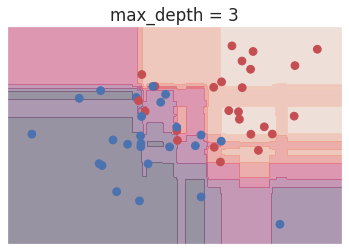

In [ ]:
plot_forest(3)

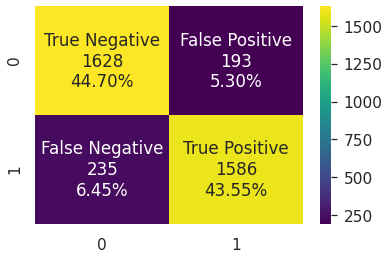

In [ ]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
sns.set(font_scale=1.4)

cf_matrix = confusion_matrix(y_test, rf_combined.predict(X_test))

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='viridis')


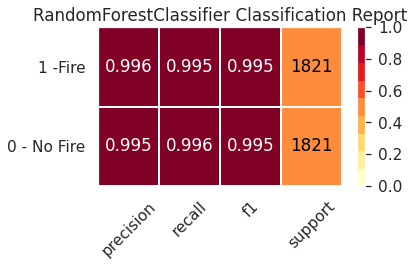

In [ ]:
from yellowbrick.classifier import ClassificationReport
#X_train, X_test, y_train, y_test
sns.set(font_scale=1.4)

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(rf_combined, classes=['0 - No Fire','1 -Fire'], support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()             # Draw/show/poof the data

Best Threshold=0.480000, G-Mean=0.954


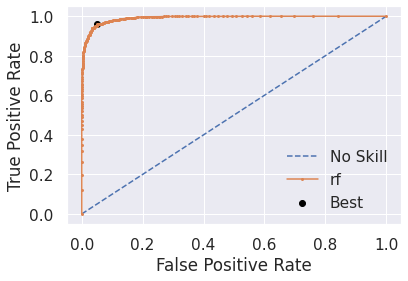

In [ ]:
# show the plot
pyplot.show()
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
#Adjusting the threshold gave better results
threshold = 0.478619

predicted_proba = rf_combined.predict_proba(X_test)
predicted1 = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted1)
print(accuracy)
actual = y_test
predicted = (predicted_proba [:,1] >= threshold).astype('int')
results = confusion_matrix(actual, predicted) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(actual, predicted))
print('Report : ')
print(classification_report(actual, predicted))

0.9953322350356947
Confusion Matrix :
[[1812    9]
 [   8 1813]]
Accuracy Score : 0.9953322350356947
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1821
           1       1.00      1.00      1.00      1821

    accuracy                           1.00      3642
   macro avg       1.00      1.00      1.00      3642
weighted avg       1.00      1.00      1.00      3642



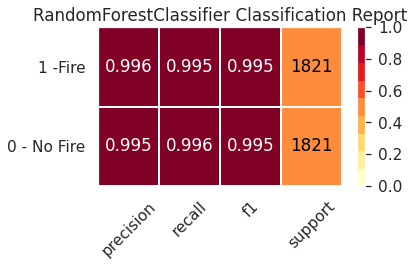

In [ ]:
sns.set(font_scale=1.4)

from yellowbrick.classifier import ClassificationReport
#X_train, X_test, y_train, y_test

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(rf_weather, classes=['0 - No Fire','1 -Fire'], support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()             # Draw/show/poof the data

Text(0.5, 1.0, '2-class Precision-Recall curve\nwith Average Precision(AP)')

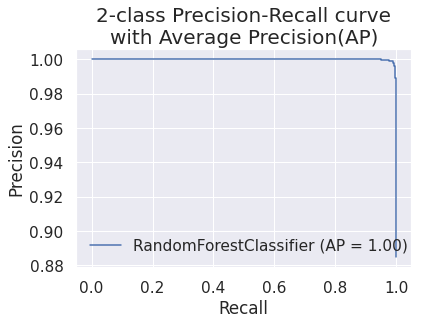

In [ ]:
#Plot the Precision-Recall curve (AP-Average Precision)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(rf_combined, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve\nwith Average Precision(AP)', fontsize=20)

In [ ]:
# print(k)

In [ ]:
from sklearn import metrics

predicted_proba = rf_combined.predict_proba(X_test)
print("Area under the curve (AUC):",metrics.roc_auc_score(y_test, predicted_proba[:,1]))

Area under the curve (AUC): 0.9998415278942571


Best Threshold=0.495000, G-Mean=1.00


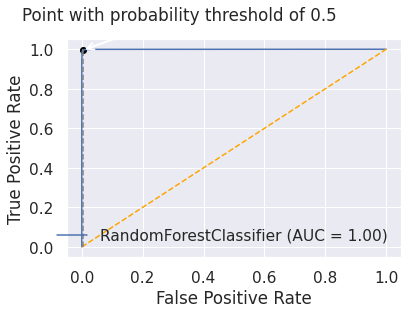

In [ ]:
from sklearn.metrics import plot_roc_curve,roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import math


# Plot the ROC curve
rf_disp = plot_roc_curve(rf_combined, X_test, y_test)

# Generate a no skill prediction (majority class) for proper legend - else use plt.plot([0, 1], ls="--") or use plt.plot([0,1], [0,1], linestyle='--', color = 'orange', label='No Skill ClassifiCATION (AUC=0.5)')
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ns_auc = roc_auc_score(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, color='orange',linestyle='--', label='No Skill Classification (AUC={})'.format(ns_auc))
# Can do for each point threshold value - for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):plt.annotate(np.round(txt,2), (x, y-0.04))

# Calculate roc curve again for understanding the threshold 
fpr, tpr, thresholds = roc_curve(y_test, predicted_proba[:,1])
gmeans = sqrt(tpr * (1-fpr))          # Calculate the g-mean for each threshold as it is ideal for unbalanced dataset
ix = argmax(gmeans)                   # locate the index of the largest g-mean
'''Alternative - Youden’s J statistic to get the same best threshold - Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
J = tpr - fpr; ix = argmax(J); best_thresh = thresholds[ix]'''

# Show the best threshold
print('Best Threshold=%f, G-Mean=%.2f' % (thresholds[ix], gmeans[ix]))
plt.annotate('Point with probability threshold of {}'.format(np.round(thresholds[ix], 2)), 
             xy=(fpr[ix], tpr[ix]), xytext=(fpr[ix]-0.2, tpr[ix]+0.15),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold')
plt.plot([0,fpr[ix]],[tpr[ix],tpr[ix]], ls="--",color='grey');plt.plot([fpr[ix],fpr[ix]],[0,tpr[ix]], ls="--",color='grey');
#plt.legend(frameon=True,framealpha=10); plt.title("Receiver operating characteristic(ROC) curve\nwith Area under the curve(AUC)", fontsize=15)
plt.show()

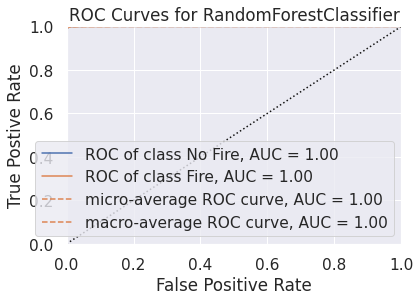

In [ ]:
# Instaniate the classification model and visualizer
from yellowbrick.classifier.rocauc import roc_auc,ROCAUC
visualizer = ROCAUC(rf_combined, classes=["No Fire", "Fire"])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof()                       # Finalize and render the figure

# Wasn't accurate: roc_auc(model_rf, X_train_df, y_train_df,X_test = X_test_df, y_test = y_test_df, classes=['No Fire', 'Fire'])

(0.0, 1.03)

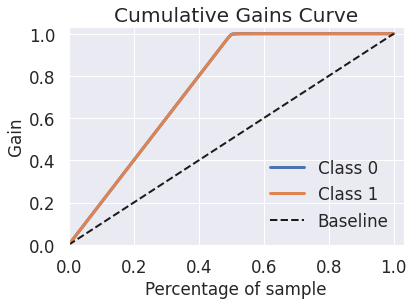

In [ ]:

skplt.metrics.plot_cumulative_gain(y_test, predicted_proba)
plt.ylim(0,1.03);plt.xlim(0,1.03)

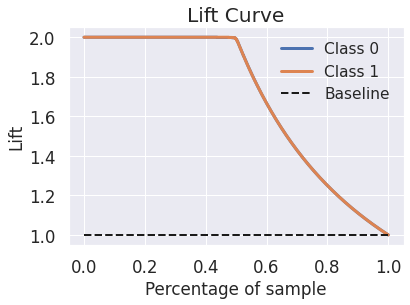

In [ ]:
# Lift curve
skplt.metrics.plot_lift_curve(y_test, predicted_proba)
plt.legend(loc=1)

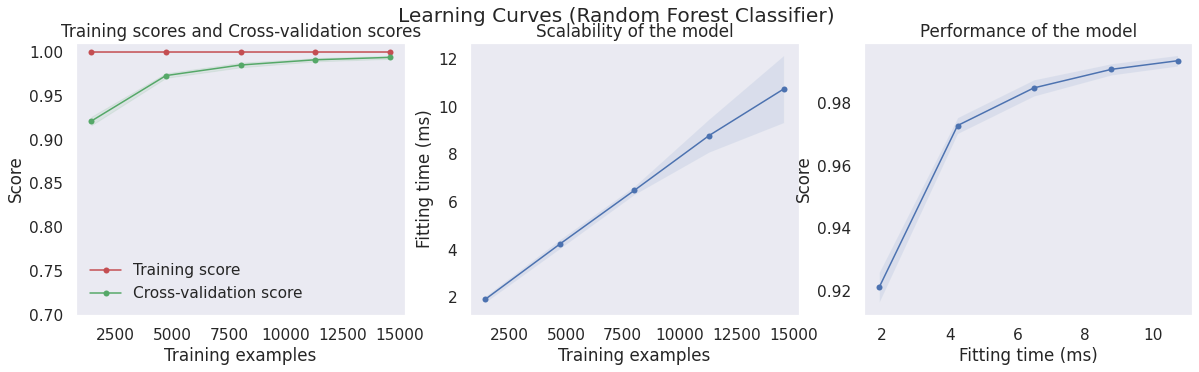

In [ ]:
# Check model performmance and learning curve
#For multiple models, use axes and fig, axes = plt.subplots(3, 1, figsize=(20, 15))

X = pd.concat([pd.DataFrame(X_train),pd.DataFrame(X_test)], axis = 0)
y = pd.concat([pd.Series(y_train),pd.Series(y_test)], axis = 0)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(rf_combined,'Learning Curves (Random Forest Classifier)',X,y,ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)
plt.suptitle("Learning Curves (Random Forest Classifier)")
plt.show()